In [1]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.3

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.2.2

openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)
  Using cached https://files.pythonhosted.org/packages/e3/53/c737818eb9a7dc32a7cd4f1396e787bd94200c3997c72c1dbe028587bd76/py4j-0.10.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/89/16492f3c61c6cfc9b41344de7c1c875f171c33cba1b8b9546dd0c4d77ff6/spark_nlp-2.2.1-py2.py3-none-any.whl


In [2]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp

--2019-09-24 14:40:24--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.168.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.168.93|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/tmp/train-balanced-sarcasm.csv’ not modified on server. Omitting download.



In [0]:
import os
import sys
import time
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
packages = [
    'JohnSnowLabs:spark-nlp:2.2.1'
]
spark = SparkSession \
    .builder \
    .appName("ML SQL session") \
    .config('spark.jars.packages', ','.join(packages)) \
    .config("spark.driver.memory","16g") \
    .getOrCreate()

In [4]:
import sparknlp

print("Spark NLP version")
sparknlp.version()
print("Apache Spark version")
spark.version

Spark NLP version
2.2.1
Apache Spark version


'2.4.3'

In [5]:
from pyspark.sql import SQLContext

sql = SQLContext(spark)

trainBalancedSarcasmDF = spark.read.option("header", True).option("inferSchema", True) \
    .csv("/tmp/train-balanced-sarcasm.csv")
trainBalancedSarcasmDF.printSchema()

# Let's create a temp view (table) for our SQL queries
trainBalancedSarcasmDF.createOrReplaceTempView('sarcasm')

sql.sql('SELECT COUNT(*) FROM sarcasm').collect()

root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: string (nullable = true)
 |-- ups: string (nullable = true)
 |-- downs: string (nullable = true)
 |-- date: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- parent_comment: string (nullable = true)



[Row(count(1)=1010826)]

In [6]:
df = sql.sql('''
select label, concat(parent_comment,"\n",comment) as comment 
from sarcasm 
where comment is not null and parent_comment is not null limit 10000''')
print(type(df))
df.printSchema()
print('rows', df.count())
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)

rows 10000
+-----+--------------------+
|label|             comment|
+-----+--------------------+
|    0|Yeah, I get that ...|
|    0|The blazers and M...|
|    0|They're favored t...|
|    0|deadass don't kil...|
|    0|Yep can confirm I...|
|    0|do you find arian...|
|    0|What's your weird...|
|    0|Probably Sephirot...|
|    0|What to upgrade? ...|
|    0|Probably count Ka...|
|    0|I bet if that mon...|
|    0|James Shields Wil...|
|    0|There's no time t...|
|    0|Team Specific Thr...|
|    0|Ill give you a hi...|
|    0|Star Wars, easy. ...|
|    0|You're adorable.
...|
|    0|He actually acts ...|
|    0|Clinton struggles...|
|    0|Is that the Older...|
+-----+--------------------+
only showing top 20 rows



In [7]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

from pyspark.ml import Pipeline

document_assembler = DocumentAssembler() \
    .setInputCol("comment") \
    .setOutputCol("document")
    
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") \
    .setUseAbbreviations(True)
    
tokenizer = Tokenizer() \
  .setInputCols(["sentence"]) \
  .setOutputCol("token")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer])
nlp_model = nlp_pipeline.fit(df)

processed = nlp_model.transform(df)
processed.show()

train, test = processed.randomSplit(weights=[0.7, 0.3], seed=123)

print(train.count())
print(test.count())

+-----+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|Yeah, I get that ...|[[document, 0, 90...|[[document, 0, 25...|[[token, 0, 3, Ye...|
|    0|The blazers and M...|[[document, 0, 20...|[[document, 0, 13...|[[token, 0, 2, Th...|
|    0|They're favored t...|[[document, 0, 14...|[[document, 0, 22...|[[token, 0, 6, Th...|
|    0|deadass don't kil...|[[document, 0, 90...|[[document, 0, 90...|[[token, 0, 6, de...|
|    0|Yep can confirm I...|[[document, 0, 11...|[[document, 0, 48...|[[token, 0, 2, Ye...|
|    0|do you find arian...|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 1, do...|
|    0|What's your weird...|[[document, 0, 98...|[[document, 0, 52...|[[token, 0, 5, Wh...|
|    0|Probably Sephirot...|[[document, 0, 14...|[[document, 0, 18...|[[token, 0

In [8]:
glove = WordEmbeddingsModel.pretrained()
train_featurized = glove.transform(train)
train_featurized.show()

glove_100d download started this may take some time.
Approximate size to download 144.3 MB
[OK!]
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|"""...newtons."" ...|[[document, 0, 72...|[[document, 0, 72...|[[token, 0, 5, ""...|[[word_embeddings...|
|    0|"""As an excuse""...|[[document, 0, 77...|[[document, 0, 17...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Budaya Ketimur...|[[document, 0, 21...|[[document, 0, 81...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Christ Enthusi...|[[document, 0, 75...|[[document, 0, 75...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Dear so called...|[[document, 0, 68...|[[document, 0, 68...|[[token, 0, 2, ""...|[[word_embeddings...|

In [9]:
test_featurized = glove.transform(test)
test_featurized.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|"""Agreed. I thin...|[[document, 0, 13...|[[document, 0, 9,...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""An unmet playe...|[[document, 0, 27...|[[document, 0, 91...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""And an underag...|[[document, 0, 54...|[[document, 0, 54...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Define Capital...|[[document, 0, 12...|[[document, 0, 22...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Exactly. My ki...|[[document, 0, 13...|[[document, 0, 13...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Ho"" Speak lik...|[[document, 0, 45...|[[document, 0, 45...|[[token, 0, 2, ""...|[[wor

In [0]:
def get_features(row):
    result = []
    for tk in row:
        result.append(tk['embeddings'])
    return np.array(result)

def build_data(df, chunks=10):
    x_train = []
    y_train = []

    row_count = df.count()
    i = 0
    
    chunks = df.randomSplit(weights=[1/chunks] * chunks)

    for chunk in chunks:
        rows = chunk.collect()
        for row in rows:
            if i % 1000 == 0:
                print('row {} / {} ({:.1f} %)'.format(i, row_count, 100 * i / row_count))
            embeddings = get_features(row['embeddings'])
            label = row['label']
            x_train.append(embeddings)
            y_train.append(label)
            i += 1

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    return x_train, y_train

In [13]:
x_train, y_train = build_data(train_featurized)

row 0 / 6948 (0.0 %)
row 1000 / 6948 (14.4 %)
row 2000 / 6948 (28.8 %)
row 3000 / 6948 (43.2 %)
row 4000 / 6948 (57.6 %)
row 5000 / 6948 (72.0 %)
row 6000 / 6948 (86.4 %)


In [14]:
x_test, y_test = build_data(test_featurized)

row 0 / 3052 (0.0 %)
row 1000 / 3052 (32.8 %)
row 2000 / 3052 (65.5 %)
row 3000 / 3052 (98.3 %)


In [0]:
spark.stop()

In [16]:
print('Train Labels:\n', pd.Series(y_train).value_counts())
print('Test Labels:\n', pd.Series(y_test).value_counts())

Train Labels:
 0    4385
1    2563
dtype: int64
Test Labels:
 0    1905
1    1147
dtype: int64


In [17]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

# set parameters for our model:
maxlen = 100 #max 50 words per article
batch_size = 32 #size of the batch 
filters = 50 #dimension of filters for the convolutional layer
kernel_size = 3 #size of the kernel used in the convolutional layer
hidden_dims = 250 #dimension of the hidden layer
epochs = 5 #number of training epochs

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Using TensorFlow backend.


In [18]:
print('Build model...')
model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

from keras import backend as K


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mae'])

Build model...




In [19]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6948 samples, validate on 3052 samples
Epoch 1/5
6948/6948 [==============================] - 4s 584us/step - loss: 0.6613 - acc: 0.6277 - mean_absolute_error: 0.4648 - val_loss: 0.6692 - val_acc: 0.6242 - val_mean_absolute_error: 0.4422
Epoch 2/5
6948/6948 [==============================] - 3s 442us/step - loss: 0.6303 - acc: 0.6530 - mean_absolute_error: 0.4421 - val_loss: 0.6368 - val_acc: 0.6465 - val_mean_absolute_error: 0.4522
Epoch 3/5
6948/6948 [==============================] - 3s 434us/step - loss: 0.5753 - acc: 0.7031 - mean_absolute_error: 0.3994 - val_loss: 0.6399 - val_acc: 0.6474 - val_mean_absolute_error: 0.4307
Epoch 4/5
6948/6948 [==============================] - 3s 432us/step - loss: 0.4969 - acc: 0.7585 - mean_absolute_error: 0.3432 - val_loss: 0.

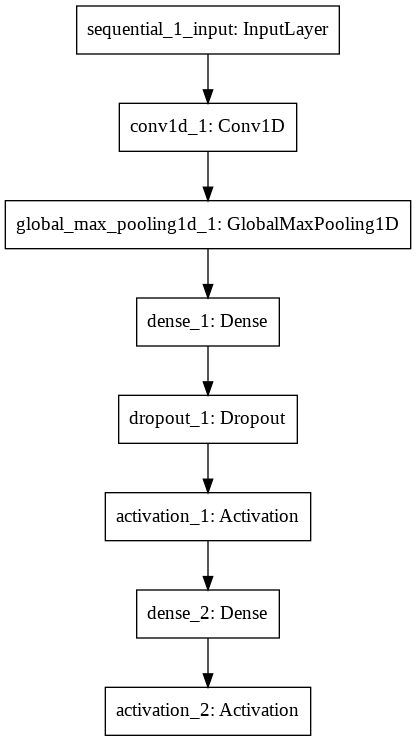

In [20]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
dot = model_to_dot(model)
Image(dot.create_png())